<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Two_Continuous_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
############################################
## This script will simulate data from known statistical distirbutions for two sample continuous mean; then estimate GAN and sample from it
## Final edit: 2023 July 4 5pm
## Authors: Betty and Chris, ft David
## Date Created: February 2023
############################################

In [ ]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv==0.18.0 --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
pandas-profiling 3.2.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
copulas 0.8.0 requires matplotlib<4,>=3.4.0; python_version >= "3.7" and python_version < "3.10", but you have matplotlib 3.1.3 which is incompatible.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU
import torch

# For plot/visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For take down the log in the loss plot
from io import StringIO

# Change color setting
sns.set_style('darkgrid')

In [ ]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

# Sample Size for Precision of Two Continuous Normal Random Variable --- by Mathematical Theory


In [ ]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [ ]:
## Sample size by math formula
# q: Proportion of subjects that are in Group 1 (exposed
# Effect size (If μ1 = mean in Group 1 and μ0 = mean in Group 0, then E = μ1 - μ0.)
def samp_size_2mean(alpha, beta, q1, q0, effectsize, sigma):
    A = 1/q1 + 1/q0
    B = (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+scipy.stats.norm.ppf(q=beta, loc=0, scale=1))**2
    n = (A*B/((effectsize/sigma)**2))/2
    return(n)



In [ ]:
# For testing the function build
samp_size_2mean(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, effectsize=0.2, sigma=1) #784


392.4439867174545

# Sample Size for Precision of Two Continuous Normal Random Variable --- by numerical simulation

In [ ]:
## build the function to caculate sample size
def twonorm_ci_samp_size(n, m1, m2, sd):
    ## Generate random data
    x1 = np.random.normal(loc=m1, scale=sd, size=n)
    x2 = np.random.normal(loc=m2, scale=sd, size=n)

    ## Analyze generated/simulated data
    # mu_vec = np.array([m1,m2])
    # sigma_matrix = np.array([sd, 0.0, 0.0, sd]).reshape((2,2))
    # x = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    # x1, x2 = x[:,0], x[:,1]

    res  = scipy.stats.ttest_ind(x1, x2, alternative='two-sided', equal_var=False)
    #res  = scipy.stats.ttest_rel(x1, x2, alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    #ttest = res[0]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({#'ttest': [ttest],
                        'pval': [pval],
                        'tag': [tag]})
    return(out)


In [ ]:
twonorm_ci_samp_size(n=10, m1=0, m2=0.2, sd=1)

,pval,tag
0,0.458129,0


In [ ]:
## Replicate above function number of simulation replicate times

# parameter available
alpha=0.05
beta=0.2
q1=0.5
q0=0.5
effectsize=0.2
sigma=1
n = int(np.ceil(samp_size_2mean(alpha, beta, q1, q0, effectsize, sigma)))
m1 = 0
m2 = effectsize - m1
sd = 1


## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(twonorm_ci_samp_size(n, m1, m2, sd))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean
sim_power = np.mean(sim_df, axis=0)
print(sim_power)

  0%|          | 0/10000 [00:00<?, ?it/s]

pval    0.046153
tag     0.802700
dtype: float64


In [ ]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    ## ?? 'correlation': [sim_means[0]],
    'pvalue': [sim_power[0]],
    'power': [sim_power[1]]
})

sim_results

,runtime,pvalue,power
0,11.682121,0.046153,0.8027


# Sample size estimation by GAN simulation

In [ ]:
#Build up and save the log for loss plot later
import sys

path = 'logs.txt'
sys.stdout = open(path, 'w')

In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu1, pop_mu2, pop_sd, pop_n):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x1 = np.random.normal(loc=pop_mu1, scale=pop_sd, size=pop_n)
    x2 = np.random.normal(loc=pop_mu2, scale=pop_sd, size=pop_n)
    x_pd = pd.DataFrame({'x1': x1, 'x2': x2})

    #   ## Convert vector to pandas dataFrame
    #x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    # CTGAN doesnt need to be seeded
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)

    ## Return the learned model
    out = [model, x_pd]

    return out




In [ ]:
# %%time
# %%capture output

## Parameters of normal parent distribution
mu1 = 0
mu2 = 0.2
sd = 1
n = 10000

## Get the learned GAN model --- after training
t0 = time()
train_gan = train_gan_model_normal(pop_mu1=mu1, pop_mu2= mu2, pop_sd=sd, pop_n=n)
t1 = time()
fit_time = t1 - t0
fit_time

542.4020128250122

In [ ]:
# build the loss file
with open('logs.txt') as file:
    lines = file.readlines()

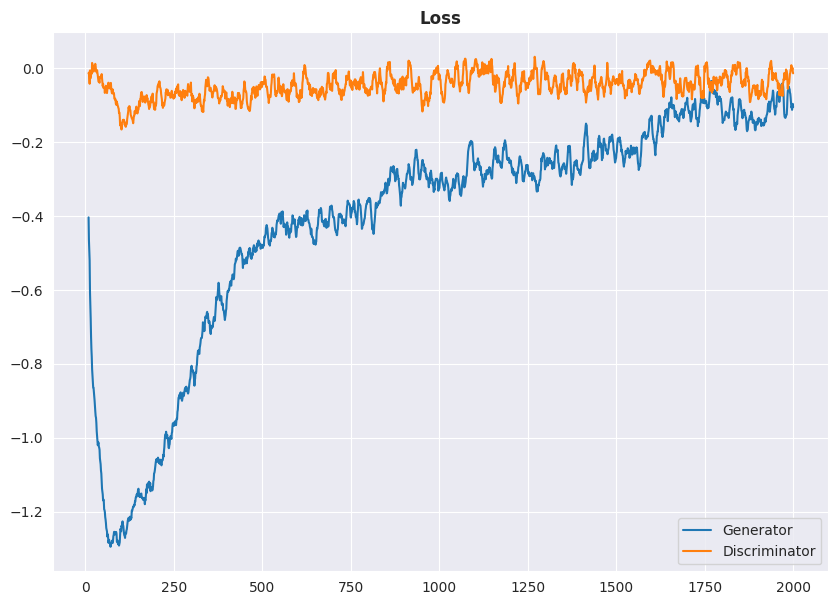

In [ ]:
output = "".join(lines)
name = 'Loss'

output = StringIO(str(output))
window = 10

df = pd.read_csv(output, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

# plt.xlim(0, 1000)

plt.title(name, weight='bold')
plt.legend()
plt.show()

In [ ]:
##############################
# testing the output
##############################
model_ = train_gan[0]

In [ ]:
model_.sample(num_rows=10000).mean(axis=0)

x1   -0.020527
x2    0.201964
dtype: float64

In [ ]:
model_.get_parameters

<bound method BaseTabularModel.get_parameters of <sdv.tabular.ctgan.CTGAN object at 0x7faac4698e80>>

In [ ]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x1,x2
count,10000.000000,10000.000000
mean,-0.009047,0.198402
std,0.998623,0.988229
min,-3.757413,-3.452711
25%,-0.682531,-0.468045
50%,-0.015767,0.197139
75%,0.669363,0.871859
max,3.710178,3.843226


In [ ]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_2mean(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, effectsize=0.2, sigma=1)))

In [ ]:
dat= model_.sample(num_rows=5)
dat

,x1,x2
0,-1.742405,1.476298
1,-1.415738,0.723700
2,-0.056219,1.133281
3,0.588074,-0.258397
4,-0.654296,0.140220


In [ ]:
dat.iloc[:, 0]

0   -1.742405
1   -1.415738
2   -0.056219
3    0.588074
4   -0.654296
Name: x1, dtype: float64

In [ ]:
dat.iloc[:, 1]

0    1.476298
1    0.723700
2    1.133281
3   -0.258397
4    0.140220
Name: x2, dtype: float64

In [ ]:
dat["x1"]

0   -1.742405
1   -1.415738
2   -0.056219
3    0.588074
4   -0.654296
Name: x1, dtype: float64

In [ ]:
## Function to analyze data from the sampled model
def twonorm_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n)

    ## Analyze generated/simulated data
    res = scipy.stats.ttest_ind(dat.iloc[:, 0],dat.iloc[:, 1], alternative='two-sided', equal_var=False)
    ## Extract the p value and power
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'pval': [pval],
                        'tag': [tag]})

    # Return the estimate and the CI to the user
    return(out)

In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(twonorm_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean
gan_power = np.mean(gan_df, axis=0)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
gan_power

pval    0.00879
tag     0.95950
dtype: float64

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [gan_power[0]],
    'power': [gan_power[1]]
})

gan_results

,runtime,pvalue,power
0,233.525353,0.00879,0.9595


# Estimating sample size for a continuous CI from two normal distribution

In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from two normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05],
              'm1': [0.0],
              'm2': [0.2],
              'sd': [1],
              'effectsize': [0.2],
              'sigma' : [1],
              'q1' :[0.5],
              'q0' :[0.5],
              'beta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]} # changed 0.01 -> 0.05 to reduce training time

param_df = expand_grid(dictionary)
param_df['effectsize'] = param_df['m2'] - param_df['m1']
param_df

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30


#Sample Size for Continuous CI by Theory or Analytic Formula

In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_2mean(alpha=param_df.loc[i, 'alpha'],
                        effectsize=param_df.loc[i, 'effectsize'],
                        sigma=param_df.loc[i, 'sigma'],
                        q1=param_df.loc[i, 'q1'],
                        q0=param_df.loc[i, 'q0'],
                        beta=param_df.loc[i, 'beta']
                        )

    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

param_df['n_theory'] = samp_size_theory_list
param_df

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0


## Sample Size and Power simulation for Continuous CI by Simulation from two Normal Distribution

In [ ]:
########################
## 2) Sample Size for Continuous CI by Simulation from two Normal Distribution
########################

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def twonorm_power_samp_size(n, m1, m2, sd):

    ## Generate random data
    x1 = np.random.normal(loc=m1, scale=sd, size=n)
    x2 = np.random.normal(loc=m2, scale=sd, size=n)

    ## Analyze generated/simulated data
    res  = scipy.stats.ttest_ind(x1, x2, alternative='two-sided', equal_var=False)

    ## Extract the estimate p value and tag
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate p value and tag to the out
    out = pd.DataFrame({'pval': [pval],
                        'tag': [tag]})
    return(out)

def twonorm_power_samp_size_sim(n, m1, m2, sd, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep, leave=False):
        sim_out.append(twonorm_power_samp_size(n=n, m1=m1, m2=m2, sd=sd))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array
    sim_power = np.mean(sim_df, axis=0)
    # print(sim_power)

    sim_results = pd.DataFrame({'runtime': [runtime],
                                'pvalue': [sim_power[0]],
                                'power': [sim_power[1]]
      })

    return(sim_results)

In [ ]:
power= twonorm_power_samp_size_sim(n=10, m1=0, m2=0.1, sd=1, n_rep=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
param_df

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0


In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000
m_rep = 2

t0 = time()

for i in trange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power = twonorm_power_samp_size_sim(
        n=int(float(param_df.loc[i, 'n_theory'])),
        m1=param_df.loc[i, 'm1'],
        m2=param_df.loc[i, 'm2'],
        sd=param_df.loc[i, 'sd'],
        n_rep=n_rep
    )
    ## Round to largest integer
    power_ = power['power'].values[0]

    samp_size_sim_list.append(power_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
param_df['power_sim'] = samp_size_sim_list
param_df
# CHANGE THE BETA !!!!!!!!!!!!!
# TEST THE ERROR RATE + EFFECTIVE OR NOT


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory,power_sim
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0,0.9523
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0,0.8962
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0,0.8475
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0,0.7963
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0,0.7532
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0,0.6905


In [ ]:
# param_df['power_sim_mean'] = param_df['power_sim'].apply(lambda x: np.mean(x))
# param_df['power_sim_sd'] = param_df['power_sim'].apply(lambda x: np.std(x))

In [ ]:
param_df

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory,power_sim
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0,0.9523
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0,0.8962
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0,0.8475
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0,0.7963
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0,0.7532
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0,0.6905


## Sample Size for Continuous CI by Simulation from trained GAN

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def twonorm_power_samp_size_gan(model, n):

    X = model.sample(num_rows=n)

    ## Generate random data
    x1 = X['x1'].values
    x2 = X['x2'].values

    ## Analyze generated/simulated data
    res  = scipy.stats.ttest_ind(x1, x2, alternative='two-sided', equal_var=False)

    ## Extract the estimate p value and tag
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate p value and tag to the out
    out = pd.DataFrame({'pval': [pval],
                        'tag': [tag]})
    return(out)

def twonorm_power_samp_size_sim_gan(model, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep, leave=False):
        sim_out.append(twonorm_power_samp_size_gan(model, n))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array
    sim_power = np.mean(sim_df, axis=0)
    print(sim_power)

    sim_results = pd.DataFrame({'runtime': [runtime],
                                'pvalue': [sim_power[0]],
                                'power': [sim_power[1]]
      })

    return(sim_results)

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in trange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power = twonorm_power_samp_size_sim_gan(
        model_,
        n=int(float(param_df.loc[i, 'n_theory'])),
        n_rep=n_rep
    )
    ## Round to largest integer
    power_ = power['power'].values[0]
    ## Append sample size to list
    samp_size_gan_list.append(power_)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
## Compile results into dataFrame
param_df['power_gan'] = samp_size_gan_list
param_df

#
# TEST THE ERROR RATE + EFFECTIVE OR NOT


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory,power_sim,power_gan
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0,0.9523,0.999
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0,0.8962,0.990
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0,0.8475,0.979
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0,0.7963,0.952
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0,0.7532,0.937
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0,0.6905,0.884


In [ ]:
# build the final error table
param_df['power_theory'] = 1 - param_df['beta']

param_df['power_gan'] = param_df['power_gan']
# param_df['relative_error'] = 100 * (param_df['power_sim'] - param_df['power_gan']).abs() /  param_df['power_sim']


param_df['relative_error_sim'] = 100 * (param_df['power_theory'] - param_df['power_sim']).abs() /  param_df['power_theory']
param_df['relative_error_gan'] = 100 * (param_df['power_theory'] - param_df['power_gan']).abs() /  param_df['power_theory']

#Final table for comparasion
param_df


,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta,n_theory,power_sim,power_gan,power_theory,relative_error_sim,relative_error_gan
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,650.0,0.9523,0.999,0.95,0.242105,5.157895
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,526.0,0.8962,0.990,0.90,0.422222,10.000000
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,449.0,0.8475,0.979,0.85,0.294118,15.176471
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,393.0,0.7963,0.952,0.80,0.462500,19.000000
4,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.25,348.0,0.7532,0.937,0.75,0.426667,24.933333
5,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.30,309.0,0.6905,0.884,0.70,1.357143,26.285714


In [ ]:
power_theory = 1 - param_df['beta']
error = 100 * (power_theory - param_df['power_sim']).abs() / power_theory
error

0    0.242105
1    0.422222
2    0.294118
3    0.462500
4    0.426667
5    1.357143
dtype: float64

In [ ]:
power_theory = 1 - param_df['beta']
error = 100 * (power_theory - param_df['power_gan']).abs() / power_theory
error

0     5.157895
1    10.000000
2    15.176471
3    19.000000
4    24.933333
5    26.285714
dtype: float64

In [ ]:
## Timing for GAN in the simulation experiments
gan_time

151.34029603004456

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [ ]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-29'

In [ ]:
## Session Info
from sinfo import sinfo
sinfo()

In [ ]:
## Jupyter version
!jupyter --version

In [ ]:
## Python version
!python --version

# Plot for simulated data vs Real


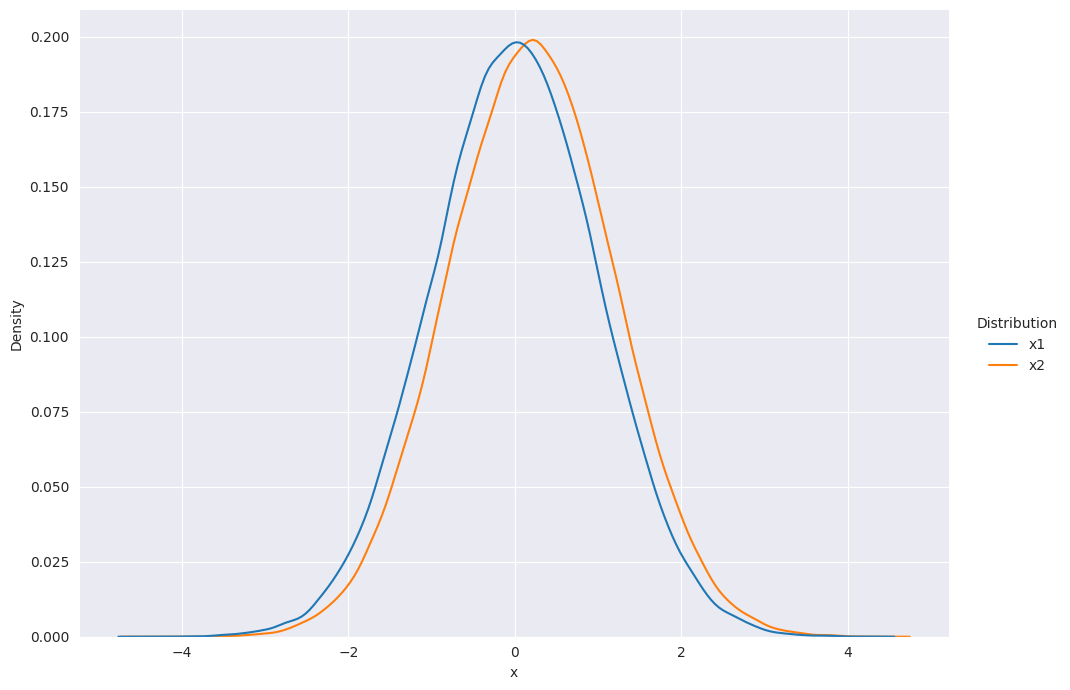

In [ ]:
#Plot of the density plot for the real data
N = 100_000

model_ = train_gan[0]

X_generator = model_.sample(num_rows=N)

X_real1 = np.random.normal(loc=mu1, scale=sd, size=N)
# fig, ax = plt.subplots(1,1)
X_real2 = np.random.normal(loc=mu2, scale=sd, size=N)

data = pd.DataFrame(data={'x': list(X_real1) + list(X_real2) , 'Distribution': N * ['x1'] + N * ['x2']})

sns.displot(data=data, x='x', hue='Distribution', kind="kde", height=7, aspect=1.4)
plt.show()

# df = pd.DataFrame()
# for i in range(8):
#     mean = 5-10*np.random.rand()
#     std = 6*np.random.rand()
#     df['score_{0}'.format(i)] = np.random.normal(mean, std, 60)

# fig, ax = plt.subplots(1,1)
# for s in df.columns:
#     df[s].plot(kind='density')
# fig.show()

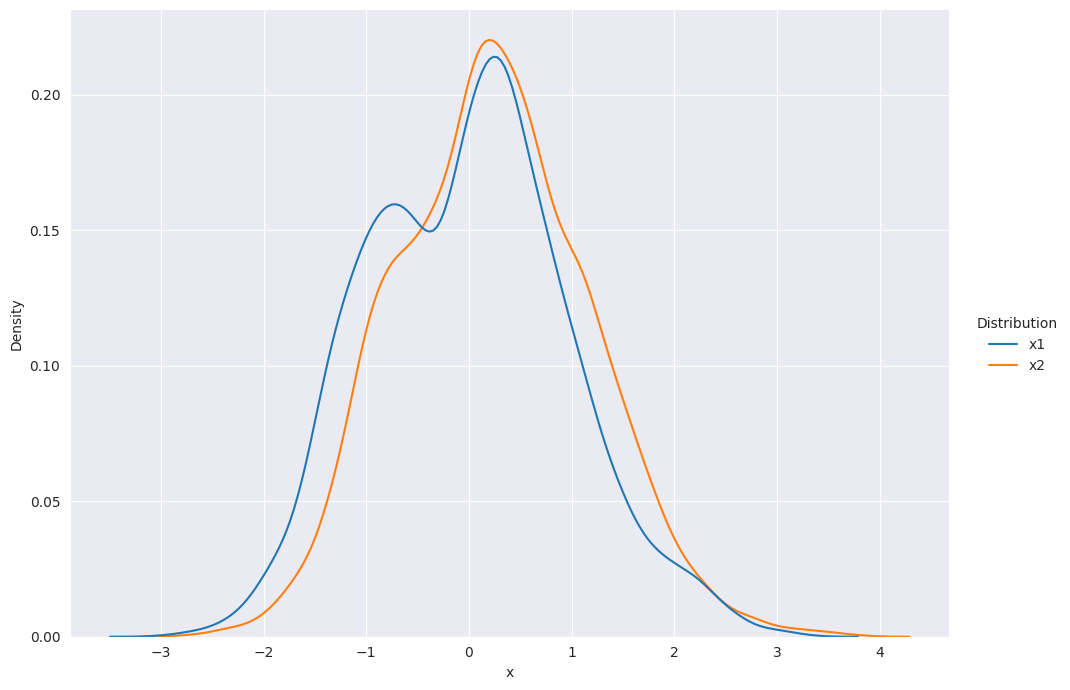

In [ ]:
## Plot of the density plot for the simulated data from GAN
N = 10_000

model_ = train_gan[0]

X_generator = model_.sample(num_rows=N)

X_real1 = np.random.normal(loc=mu1, scale=sd, size=N)
# fig, ax = plt.subplots(1,1)
X_real2 = np.random.normal(loc=mu2, scale=sd, size=N)

data = pd.DataFrame(data={'x': X_generator['x1'].tolist() + X_generator['x2'].tolist() , 'Distribution': N * ['x1'] + N * ['x2']})

sns.displot(data=data, x='x', hue='Distribution', kind="kde", height=7, aspect=1.4)
plt.show()

# df = pd.DataFrame()
# for i in range(8):
#     mean = 5-10*np.random.rand()
#     std = 6*np.random.rand()
#     df['score_{0}'.format(i)] = np.random.normal(mean, std, 60)

# fig, ax = plt.subplots(1,1)
# for s in df.columns:
#     df[s].plot(kind='density')
# fig.show()